## **LOCACIONES PLANTAS CLIENTES - ESCENARIOS**

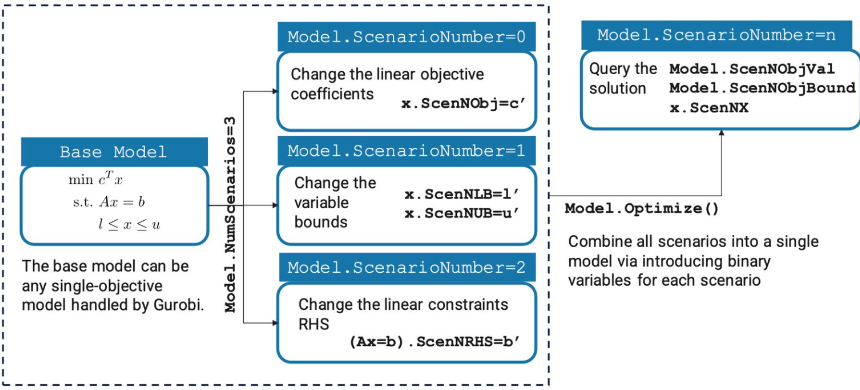

In [91]:
import gurobipy as gp
from gurobipy import GRB
import pandas
import plotly.graph_objects as go

In [92]:
df_costo_cliente_planta = pandas.read_excel("./data.xlsx", sheet_name="COSTO CLIENTE-PLANTA", index_col=[0, 1])
df_demanda = pandas.read_excel("./data.xlsx", sheet_name="DEMANDAS CLIENTES", index_col=0)
df_plantas = pandas.read_excel("./data.xlsx", sheet_name="COSTO Y CAPACIDAD PLANTAS", index_col=0)

**Conjuntos**

**Conjuntos**
$$ P: \text{Plantas} = \{1, 2,...,30\} $$
$$ C: \text{Clientes} = \{1, 2,...,50\} $$

**Parámetros**
$$ \text{CostoApertura}_{p}: \text{Costo de abrir la planta } p\in P $$
$$ \text{Capacidad}_{p}: \text{Capacidad máxima de la planta } p\in P $$
$$ \text{Demanda}_{c}: \text{Demanda del cliente } c\in C $$
$$ \text{CostoAsignacion}_{p,c}: \text{Costo de asignar la planta } p\in P \text{ al cliente } c\in C $$

**Variables**
$$ X_{p} = \left\{ \begin{array}{cl}
1: \text{Si abro la planta } p \in P \\
0: \text{dlc}
\end{array} \right. $$
$$ Y_{pc} = \left\{ \begin{array}{cl}
1: \text{Si asigno el cliente } c \in C \text{ a la planta } p \in P \\
0: \text{dlc}
\end{array} \right. $$

**Función Objetivo**
$$ \text{minimizar } \text{FO} = \sum_{p\in P} \text{CAP}_{p} \times X_{p} + \sum_{p\in P} \sum_{c\in C} \text{CCP}_{pc} \times Y_{pc} $$


**Restricciones**
$$ \forall p\in P \, \forall c\in C: Y_{pc} \le X_{p} $$
$$ \forall p\in P: \sum_{c\in C} Y_{pc} \times D_{c} \le \text{CAPAC}_{p} $$
$$ \forall c\in C: \sum_{p\in P} Y_{pc} = 1 $$
$$ \forall p\in P: \sum_{c\in C} Y_{pc} \ge 3 X_{p}$$
$$ \forall p\in P: \sum_{c\in C} Y_{pc} \times D_{c} \ge 0.9 * \text{CAPAC}_{p} X_{p} $$

In [93]:
model = gp.Model()

PLANTAS = df_plantas.index.to_list()
CLIENTES = df_demanda.index.to_list()

x = model.addVars(PLANTAS, vtype=GRB.BINARY, name="x")
y = model.addVars([(planta, cliente) for planta in PLANTAS for cliente in CLIENTES], vtype=GRB.BINARY, name="y")

costo_abrir_plantas = gp.quicksum(x[planta] * df_plantas.loc[planta, "Costo de abrir"] for planta in PLANTAS)
costo_cliente_planta = gp.quicksum(y[(planta, cliente)] * df_costo_cliente_planta.loc[(planta, cliente), "Costo de asignar un cliente a un planta"] for planta in PLANTAS for cliente in CLIENTES)
model.setObjective(costo_abrir_plantas + costo_cliente_planta, GRB.MINIMIZE)

for planta in PLANTAS:
    for cliente in CLIENTES:
        model.addConstr(y[(planta, cliente)] <= x[planta], name=f"ct1_{planta}_{cliente}")
        
ctr_max_capac = model.addConstrs(
    (gp.quicksum(y[(planta, cliente)] * df_demanda.loc[cliente, "Demanda"] for cliente in CLIENTES) <= df_plantas.loc[planta, "Capacidad máxima"] for planta in PLANTAS),
    name=f"ct2_{planta}",
)

for cliente in CLIENTES:
    model.addConstr(gp.quicksum(y[(planta, cliente)] for planta in PLANTAS) == 1, name=f"ct3_{cliente}")

for planta in PLANTAS:
    model.addConstr(gp.quicksum(y[(planta, cliente)] for cliente in CLIENTES) >= 3 * x[planta], name=f"ct4_{planta}")

ctr_min_capac = model.addConstrs(
    (gp.quicksum(y[(planta, cliente)] * df_demanda.loc[cliente, "Demanda"] for cliente in CLIENTES) >= 0.9 * df_plantas.loc[planta, "Capacidad máxima"] * x[planta] for planta in PLANTAS),
    name=f"ct5_{planta}",
)

model.update()

In [94]:
model.NumScenarios = 3

In [95]:
model.Params.ScenarioNumber = 0
model.ScenNName = "Base model"

In [96]:
model.Params.ScenarioNumber = 1
model.ScenNName = "Costo de apertura constante"
for planta in PLANTAS:
    x[planta].ScenNObj = 1000

In [97]:
model.Params.ScenarioNumber = 2
model.ScenNName = "Aumento capacidad máxima planta"
for planta in PLANTAS:
    ctr_max_capac[planta].ScenNRhs = 1.2 * df_plantas.loc[planta, "Capacidad máxima"]


In [98]:
model.setParam("TimeLimit", 20)
model.optimize()

Set parameter TimeLimit to value 20
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1110 rows, 1020 columns and 6040 nonzeros
Model fingerprint: 0x4f28f92f
Variable types: 0 continuous, 1020 integer (1020 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [1e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]

Solving a multi-scenario model with 3 scenarios...

Presolve removed 150 rows and 33 columns
Presolve time: 0.07s
Presolved: 981 rows, 1010 columns, 6858 nonzeros
Presolved model has 3 scenario(s)
Variable types: 0 continuous, 1010 integer (1010 binary)

Root relaxation: objective 3.155545e+03, 870 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds     

In [100]:
for s in range(model.NumScenarios):
    model.Params.ScenarioNumber = s
    print(f"##### Escenario {s}: {model.ScenNName} #####")
    print(f"Funcion Objetivo: {model.ScenNObjVal}")
    print(f"Plantas abiertas: {sum([x[planta].ScenNX for planta in PLANTAS])}")
    
    for planta in PLANTAS:
        if x[planta].ScenNX > 0.9:
            CLIENTES_ATENDIDOS = []
            for cliente in CLIENTES:
                if y[(planta, cliente)].ScenNX > 0.9:
                    CLIENTES_ATENDIDOS.append(cliente)
            print(f"=== Planta {planta}: {CLIENTES_ATENDIDOS}")
    
    print("\n\n")
            

##### Escenario 0: Base model #####
Funcion Objetivo: 41754.0
Plantas abiertas: 15.0
=== Planta 1: [5, 15, 16, 24]
=== Planta 3: [7, 10, 38]
=== Planta 4: [3, 17, 49]
=== Planta 6: [4, 31, 40, 50]
=== Planta 9: [14, 32, 36]
=== Planta 10: [13, 25, 47]
=== Planta 11: [11, 22, 23]
=== Planta 12: [19, 21, 42]
=== Planta 13: [18, 26, 43]
=== Planta 14: [8, 12, 28]
=== Planta 15: [9, 37, 39]
=== Planta 16: [1, 6, 27, 45]
=== Planta 17: [29, 33, 46]
=== Planta 18: [2, 20, 34, 35]
=== Planta 19: [30, 41, 44, 48]



##### Escenario 1: Costo de apertura constante #####
Funcion Objetivo: 13686.0
Plantas abiertas: 13.0
=== Planta 2: [5, 6, 24]
=== Planta 6: [3, 7, 30, 47]
=== Planta 8: [23, 40, 45, 50]
=== Planta 9: [10, 25, 46]
=== Planta 10: [4, 43, 48, 49]
=== Planta 12: [19, 36, 42]
=== Planta 13: [13, 21, 28]
=== Planta 14: [8, 9, 12, 17, 37]
=== Planta 16: [1, 14, 15, 20, 27]
=== Planta 17: [29, 31, 44]
=== Planta 18: [32, 33, 34]
=== Planta 19: [11, 16, 18, 26, 35, 38, 41]
=== Planta 20: [